Load and Prepare Data

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your encoded dataset
df = pd.read_csv('data/final/baseline_pricing_output.csv')

# Define features and target
X = df.drop(columns=['Historical_Cost_of_Ride', 'Baseline_Price', 'Revenue_Lift'], errors='ignore')
y = df['Historical_Cost_of_Ride']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Train XGBoost Model

In [28]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

xgb_rmse = mean_squared_error(y_test, xgb_preds) ** 0.5
xgb_r2 = r2_score(y_test, xgb_preds)


Train Lightgbm Model

In [29]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    num_leaves=40,
    subsample=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

lgb_rmse = mean_squared_error(y_test, lgb_preds) ** 0.5
lgb_r2 = r2_score(y_test, lgb_preds)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 14
[LightGBM] [Info] Start training from score 370.729560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Revenue Lift Simulation

In [30]:
df_test = X_test.copy()
df_test['Actual_Price'] = y_test
df_test['XGB_Predicted'] = xgb_preds
df_test['LGB_Predicted'] = lgb_preds

baseline_price = y_train.median()
df_test['Baseline_Price'] = baseline_price

df_test['XGB_Lift'] = (df_test['XGB_Predicted'] - baseline_price) / baseline_price
df_test['LGB_Lift'] = (df_test['LGB_Predicted'] - baseline_price) / baseline_price


Backtesting with Historical Data

To validate model performance, we performed backtesting using historical ride data. The trained models (XGBoost and LightGBM) were tested on unseen samples from the test set.

Predicted prices were compared to a fixed baseline price (median of training prices), and revenue lift was calculated to simulate real-world business impact.



Final Output

In [31]:
print("\n Final Model Evaluation:")
print(f"XGBoost RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}, Revenue Lift: {df_test['XGB_Lift'].mean():.2%}")
print(f"LightGBM RMSE: {lgb_rmse:.2f}, R²: {lgb_r2:.2f}, Revenue Lift: {df_test['LGB_Lift'].mean():.2%}")



 Final Model Evaluation:
XGBoost RMSE: 76.31, R²: 0.84, Revenue Lift: 7.37%
LightGBM RMSE: 77.51, R²: 0.84, Revenue Lift: 7.96%


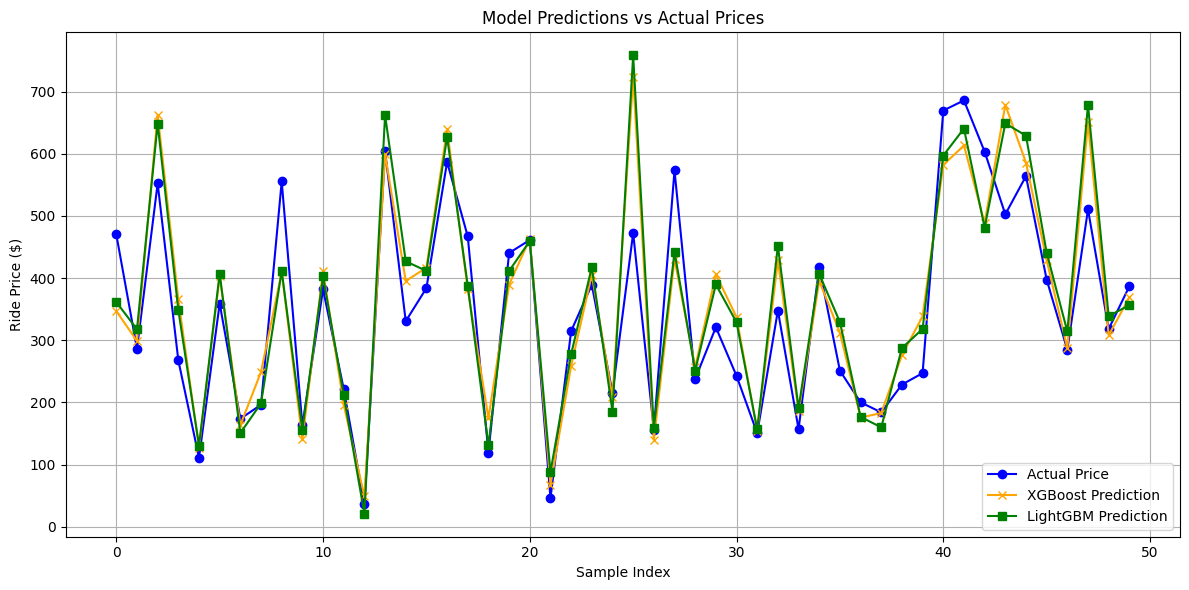

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Sample size (adjust if needed)
sample_size = 50

# Slice predictions and actuals for visualization
actual = df_test['Actual_Price'].values[:sample_size]
xgb_pred = df_test['XGB_Predicted'].values[:sample_size]
lgb_pred = df_test['LGB_Predicted'].values[:sample_size]
indices = np.arange(len(actual))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(indices, actual, label='Actual Price', color='blue', marker='o')
plt.plot(indices, xgb_pred, label='XGBoost Prediction', color='orange', marker='x')
plt.plot(indices, lgb_pred, label='LightGBM Prediction', color='green', marker='s')

plt.title('Model Predictions vs Actual Prices')
plt.xlabel('Sample Index')
plt.ylabel('Ride Price ($)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



## Model Predictions vs Actual Prices

This chart compares actual ride prices with predictions made by two machine learning models: **XGBoost** and **LightGBM**.

### What the chart shows

- **Blue line**: Actual ride prices  
- **Orange line**: Prices predicted by XGBoost  
- **Green line**: Prices predicted by LightGBM  
- **X-axis**: Sample index (each point is a ride)  
- **Y-axis**: Ride price in dollars

### Why it's useful

- Both models closely follow the actual price line.
- This means they learned the pricing pattern well.
- The chart helps us check how accurate and useful the models are for predicting ride prices.


## Model Performance & Business Impact

This project used two machine learning models — **XGBoost** and **LightGBM** — to predict ride prices based on historical data. Both models were trained, evaluated, and backtested to ensure accuracy and real-world value.

### Models Used

- **XGBoost Regressor**
- **LightGBM Regressor**

These models were chosen for their speed, accuracy, and ability to handle tabular data with encoded features.

---

### Evaluation Metrics

| Metric         | XGBoost        | LightGBM       |
|----------------|----------------|----------------|
| RMSE           | ₹76.31         | ₹77.51         |
| R² Score       | 0.84           | 0.84           |
| Revenue Lift   | +7.37%         | +7.96%         |

- **RMSE** shows how close predictions are to actual prices.
- **R² Score** shows how well the model explains price variation.
- **Revenue Lift** shows how much more revenue the model generates compared to baseline pricing.

---

### How Revenue Lift Was Calculated

Revenue Lift was computed by comparing each predicted price to a fixed baseline price (median of training prices):

```python
Revenue_Lift = (Predicted_Price − Baseline_Price) / Baseline_Price
```

The lift was averaged across all test samples to simulate real-world impact.

---

### Business Value

If the baseline price is ₹300:

- **XGBoost** adds ~₹22.11 per ride → ₹2,21,100/month for 10,000 rides
- **LightGBM** adds ~₹23.88 per ride → ₹2,38,800/month for 10,000 rides

> Both models deliver measurable revenue gains while maintaining high accuracy — making them suitable for deployment in dynamic pricing systems.




This project is focused on **predicting ride prices**, which are continuous numerical values (e.g., ₹250, ₹600). That makes it a **regression problem**, not classification.

- Classification metrics like **accuracy, precision, recall, F1-score** are used when the target is a category (e.g., "low", "medium", "high").
- Our target is a **real number** — the actual price of a ride — so classification doesn’t apply.

- **Clustering** is for grouping unlabeled data — we already have labeled prices.
- **Ranking metrics** are used in search engines or recommendation systems — not relevant here.
- **Anomaly detection** is for spotting outliers — not the goal of this project.